<a href="https://colab.research.google.com/github/RocioLiu/TensorFlow_Specialization/blob/master/tf_spec_c2CNNw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-07-14 13:41:45--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c18::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  88.9MB/s    in 0.9s    

2019-07-14 13:41:46 (88.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)  # we don't want to use the build-in weights but the snapshot that we've just downloaded

pre_trained_model.load_weights(local_weights_file)

In [14]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [15]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape: (None, 7, 7, 768)


In [16]:
print(last_output)

Tensor("mixed7_1/concat:0", shape=(?, 7, 7, 768), dtype=float32)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(lr=1e-4),
              metrics=['acc'])

In [18]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

--2019-07-14 13:42:56--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  59.8MB/s    in 1.1s    

2019-07-14 13:42:57 (59.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [0]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [21]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Epoch 1/20
100/100 [==============================] - 196s 2s/step - loss: 0.5011 - acc: 0.7465 - val_loss: 0.4429 - val_acc: 0.8800
Epoch 2/20
100/100 [==============================] - 190s 2s/step - loss: 0.3674 - acc: 0.8405 - val_loss: 0.2042 - val_acc: 0.9470
Epoch 3/20
100/100 [==============================] - 190s 2s/step - loss: 0.3467 - acc: 0.8470 - val_loss: 0.2089 - val_acc: 0.9490
Epoch 4/20
100/100 [==============================] - 191s 2s/step - loss: 0.3297 - acc: 0.8555 - val_loss: 0.3482 - val_acc: 0.9310
Epoch 5/20
100/100 [==============================] - 190s 2s/step - loss: 0.2990 - acc: 0.8770 - val_loss: 0.5019 - val_acc: 0.9250
Epoch 6/20
100/100 [==============================] - 190s 2s/step - loss: 0.2920 - acc: 0.8765 - val_loss: 0.3937 - val_acc: 0.9340
Epoch 7/20
100/100 [==============================] - 190s 2s/step - loss: 0.3014 - acc: 0.8725 - val_loss: 0.3420 - val_acc: 0.9440
Epoch 8/20
100/100 [==============================] - 190s 2s/step - 

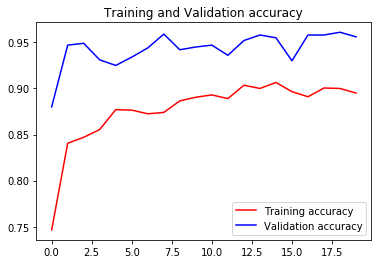

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')

plt.legend(loc=0)
plt.figure()

plt.show()

